In [ ]:
#@title Import
import numpy as np
import matplotlib.pyplot as plt
import torch, torch.nn as nn, torch.nn.functional as F
from torch.utils.data import Subset, DataLoader
from torchvision import datasets, transforms
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.manifold import MDS
from itertools import combinations, permutations
import random

In [ ]:
#@title MNIST Data Download

root = "./data"
transform = transforms.ToTensor()

train_ds = datasets.MNIST(root=root, train=True,  download=True, transform=transform)
test_ds  = datasets.MNIST(root=root, train=False, download=True, transform=transform)

print(len(train_ds), len(test_ds))

100%|██████████| 9.91M/9.91M [00:00<00:00, 34.5MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 1.09MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 9.81MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 5.51MB/s]

60000 10000


In [ ]:
#@title Preprocess Data

def seed_everything(seed:int = 0) :
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
seed_everything()

# MNIST 데이터 중에 1~8에 해당하는 숫자만 Subset
idx_train = torch.where((train_ds.targets >= 1) & (train_ds.targets <= 8))[0]
idx_test = torch.where((test_ds.targets  >= 1) & (test_ds.targets  <= 8))[0]
train_1_8 = Subset(train_ds, idx_train)
test_1_8 = Subset(test_ds, idx_test)

train_loader = DataLoader(train_1_8, batch_size=128, shuffle=True,  num_workers=2, pin_memory=True)
test_loader = DataLoader(test_1_8,  batch_size=256, shuffle=False, num_workers=2, pin_memory=True)

def parity_from_digit(d):    # even=1, odd=0
    return 1 if (int(d) % 2 == 0) else 0
def magnitude_from_digit(d): # big(5~8)=1, small(1~4)=0
    return 1 if (int(d) >= 5) else 0

In [ ]:
#@title MultiLayerPerceptron

class MultiHeadMLP(nn.Module):
    def __init__(self, in_dim=28*28, h=100):
        super().__init__()
        self.fc1 = nn.Linear(in_dim, h)
        self.fc2 = nn.Linear(h, h)
        self.parity_head = nn.Linear(h, 2)
        self.mag_head = nn.Linear(h, 2)

    def forward(self, x, return_reprs=False):
        x = x.view(x.size(0), -1)
        h1 = F.relu(self.fc1(x))
        h2 = F.relu(self.fc2(h1))
        logp = self.parity_head(h2)
        logm = self.mag_head(h2)
        if return_reprs:
            return logp, logm, x, h1, h2
        return logp, logm

model = MultiHeadMLP().to(device)
opt = torch.optim.Adam(model.parameters(), lr=1e-3)
ce = nn.CrossEntropyLoss()

def one_epoch(loader, train=True):
    model.train() if train else model.eval()
    tot, lp, lm = 0, 0.0, 0.0
    correct_p = correct_m = 0
    for imgs, labels in loader:
        imgs, labels = imgs.to(device), labels.to(device)
        yp = torch.tensor([parity_from_digit(d.item()) for d in labels], device=device)
        ym = torch.tensor([magnitude_from_digit(d.item()) for d in labels], device=device)
        if train: opt.zero_grad()
        logp, logm = model(imgs)
        loss = ce(logp, yp) + ce(logm, ym)
        if train:
            loss.backward(); opt.step()
        with torch.no_grad():
            predp = logp.argmax(1); predm = logm.argmax(1)
            correct_p += (predp == yp).sum().item()
            correct_m += (predm == ym).sum().item()
            tot += imgs.size(0)
    acc_p, acc_m = correct_p/tot, correct_m/tot
    return float(loss.item()), acc_p, acc_m

EPOCHS = 15
for ep in range(1, EPOCHS+1):
    tr_loss, tr_p, tr_m = one_epoch(train_loader, train=True)
    te_loss, te_p, te_m = one_epoch(test_loader,  train=False)
    print(f"[{ep:02d}] loss {tr_loss:.4f} | val parity {te_p:.3f} mag {te_m:.3f}")

@torch.no_grad()
def collect_hidden2(loader):
    model.eval()
    H, digits = [], []
    for imgs, labels in loader:
        imgs = imgs.to(device)
        _, _, _, _, h2 = model(imgs, return_reprs=True)
        H.append(h2.cpu().numpy())
        digits.append(labels.numpy())
    return np.vstack(H), np.concatenate(digits)

H_tr, y_tr = collect_hidden2(train_loader)
H_te, y_te = collect_hidden2(test_loader)
H = np.vstack([H_tr, H_te])         # (n_samples, 100) : Layer 2 수치
y_digits = np.concatenate([y_tr, y_te])  # (n_samples,) : 실제 label
conditions = list(range(1, 9)) #condition은 [1, 2, 3, 4, 5, 6, 7, 8]

[01] loss 0.1641 | val parity 0.974 mag 0.971
[02] loss 0.1143 | val parity 0.981 mag 0.977
[03] loss 0.1104 | val parity 0.985 mag 0.977
[04] loss 0.0313 | val parity 0.986 mag 0.982
[05] loss 0.0823 | val parity 0.987 mag 0.981
[06] loss 0.0522 | val parity 0.985 mag 0.984
[07] loss 0.0339 | val parity 0.989 mag 0.985
[08] loss 0.0077 | val parity 0.989 mag 0.984
[09] loss 0.0387 | val parity 0.988 mag 0.985
[10] loss 0.0207 | val parity 0.988 mag 0.984
[11] loss 0.0587 | val parity 0.988 mag 0.983
[12] loss 0.0132 | val parity 0.989 mag 0.984
[13] loss 0.0053 | val parity 0.986 mag 0.983
[14] loss 0.0315 | val parity 0.990 mag 0.985
[15] loss 0.0216 | val parity 0.988 mag 0.985


CCGP 연산은 모든 Train Set 과 Test Set을 반복문을 이용해 구성한 뒤, Linear Classifier(여기서는 Logistic Regression)을 각각 학습시켜 정확도를 계산한 뒤 평균 냄.

In [ ]:
#@title CCGP 연산

# condition = [1,2,3,4,5,6,7,8]을 input으로 넣으면, {1:+1, 2:+1, 3:+1, 4:+1, 5:-1, 6:-1, 7:-1, 8:-1} , 즉 (1, 2, 3, 4) / (5, 6, 7, 8) 식의 35가지 dichotomy를 dictionary 형태로 담은 list를 return
def enumerate_balanced_dichotomies(conditions):
    conds = sorted(conditions)
    half = len(conds)//2
    out = []
    for group in combinations(conds, half):
        if conds[0] not in group:            # flip 중복 방지(1을 항상 +1 쪽)
            continue
        pos = set(group)
        out.append({c: (+1 if c in pos else -1) for c in conds})
    return out  # 8개면 35개

# condition = [1,2,3,4,5,6,7,8], var map을 {1:+1, 2:+1, 3:+1, 4:+1, 5:-1, 6:-1, 7:-1, 8:-1} 으로 넣으면, [1,1,1,1,-1,-1,-1,-1] 을 return
def _to_binary(y_condition, var_map):
    return np.array([var_map[int(c)] for c in y_condition], dtype=int)

# input = [1,1,1,1,-1,-1,-1,-1] 형태의 binary list를 넣으면, +1/-1 에 해당하는 데이터의 개수를 똑같이 맞춰줌.
def _balance_idx(y, random_state=0):
    rng = np.random.RandomState(random_state) # Random Number Generator
    idx = np.arange(len(y))
    per = {v: idx[y==v] for v in np.unique(y)} # 위의 예시에 따르면, per[1]=[1,2,3,4] , per[-1] = [5,6,7,8]
    m = min(len(v) for v in per.values()) # per[1]과 per[-1] 중 list의 개수 중 작은 값
    take = [rng.choice(per[v], size=m, replace=False) for v in per] #per[1]과 per[-1]의 개수를 똑같이 맞춤
    return np.sort(np.concatenate(take)) #다시 합침

# CCGP 연산 - Linear Classifier로 Logistic Regression 사용.
# X에는 위의 H 변수와 같이 (n_samples, 100) / y_cond는 (n_samples, ) / var_map은 {1:+1, 2:+1, 3:+1, 4:+1, 5:-1, 6:-1, 7:-1, 8:-1}
# k_per_class는 4개/4개 중 몇 개를 train으로 쓸 건지, 논문에서는 3, 2, 1 모두 해보았다고 하고, Figure 3A 5A에서는 3으로 사용했다고 함.
def compute_ccgp(X, y_cond, var_map, k_per_class=2, clf="logreg", random_state=0):
    base = LogisticRegression(C=1.0, solver="liblinear", random_state=random_state) if clf=="logreg" \
           else LinearSVC(C=1.0, loss="squared_hinge", dual=False, random_state=random_state)
    probe = make_pipeline(StandardScaler(), base)

    conds = sorted(conditions)
    pos = [c for c in conds if var_map[c]==+1] # var_map에서 +1인 것들에 해당 = [1,2,3,4]
    neg = [c for c in conds if var_map[c]==-1] # var_map에서 -1인 것들에 해당 = [5,6,7,8]

    accs = []
    for pos_tr in combinations(pos, k_per_class): #pos에서 train으로 쓸 2개 고름
        for neg_tr in combinations(neg, k_per_class): #neg에서 train으로 쓸 2개 고름
            train_conds = set(pos_tr) | set(neg_tr)
            test_conds  = set(conds) - train_conds

            #Train이랑 Test에 해당하는 데이터만 masking -> 고른 데이터로 train set과 test set 구성.
            tr_mask = np.isin(y_cond, list(train_conds))
            te_mask = np.isin(y_cond, list(test_conds))
            Xtr, Xte = X[tr_mask], X[te_mask]
            ytr = _to_binary(y_cond[tr_mask], var_map)
            yte = _to_binary(y_cond[te_mask], var_map)

            keep = _balance_idx(ytr, random_state=random_state)
            Xtr, ytr = Xtr[keep], ytr[keep]
            probe.fit(Xtr, ytr) #Logistic Regression Fit
            accs.append(accuracy_score(yte, probe.predict(Xte)))
    return float(np.mean(accs)) #평균 정답률 Return


PS 연산은 24개의 Permutation에 대해 +1에 해당하는 데이터들과 -1에 해당하는 데이터들의 평균 벡터의 차를 이용해 avg cosine similarity를 계산, 이들 중 최대치가 PS

In [ ]:
#@title PS 연산

# PS 연산
# X에는 위의 H 변수와 같이 (n_samples, 100) / y_cond는 (n_samples, ) / var_map은 {1:+1, 2:+1, 3:+1, 4:+1, 5:-1, 6:-1, 7:-1, 8:-1}
def compute_ps(X, y_cond, var_map):

    # 1~8에 해당하는, {n_samples, 100}에서 Layer2값의 평균치 -> key는 1~8, value는 길이 100짜리 array인 dictionary
    means = {c: X[y_cond==c].mean(axis=0) for c in np.unique(y_cond)}
    pos = [c for c in conditions if var_map[c]==+1] # var_map에서 +1인 것들에 해당 = [1,2,3,4]
    neg = [c for c in conditions if var_map[c]==-1] # var_map에서 -1인 것들에 해당 = [5,6,7,8]
    P = len(pos)
    pos_mu = np.stack([means[c] for c in pos]) #pos에 해당하는 것들의 means dictionary 해당값
    neg_mu = np.stack([means[c] for c in neg]) #neg에 해당하는 것들의 means dictionary 해당값

    def unit_rows(A):
        n = np.linalg.norm(A, axis=1, keepdims=True) + 1e-12 #행별 Vector 길이를 계산
        return A / n #Vector 길이로 나눠서 모두 길이 1인 함수

    def avg_pairwise_cos(vecs):
        if len(vecs) < 2 : return 1.0 # vec의 개수가 1개라면 cosine similarity = 1

        dots = [] # 단위벡터에서 내적 = cosine similarity
        for i in range(len(vecs)):
            for j in range(i+1, len(vecs)):
                dots.append(float(np.dot(vecs[i], vecs[j])))
        return float(np.mean(dots)) #모든 쌍 (i, j)에 대해 내적을 계산한 뒤 평균 return

    #P = 4일 때 예시를 들면, neg_mu의 순서를 바꿔가며 pos_mu와 차이벡터를 게산하고, avg cosine similarity를 계산한 뒤 이 중 max를 return.
    best = -1e9
    for perm in permutations(range(P)):
        vecs = unit_rows(pos_mu - neg_mu[np.array(perm)])
        best = max(best, avg_pairwise_cos(vecs))
    return best

PS는, 8개 condition이라면 35개의 가능한 dichotomy에서 선형 Clasifier(여기서는 Logistic Regression)의 성능(정확도)를 Cross Validation으로 연산.

In [ ]:
#@title SD 연산
#dichots에는 가능한 dichotomy의 list를 넣음.
def compute_sd_vals(X, y_cond, dichots, n_repeats=3, test_size=0.4, random_state=0):
    probe = make_pipeline(StandardScaler(),
                          LogisticRegression(C=1.0, solver="liblinear", random_state=random_state))
    vals = []
    for var in dichots:
        y = _to_binary(y_cond, var) #[1,1,1,1,-1,-1,-1,-1] 와 같은 binary 형태로
        keep = _balance_idx(y, random_state=random_state)
        Xb, yb = X[keep], y[keep]
        sss = StratifiedShuffleSplit(n_splits=n_repeats, test_size=test_size, random_state=random_state) #Cross Validation 용도
        accs = []
        for tr, te in sss.split(Xb, yb):
            probe.fit(Xb[tr], yb[tr])
            accs.append(accuracy_score(yb[te], probe.predict(Xb[te]))) #로지스틱 회귀에서 정확도가 높을수록 선형 분리가 잘 됨.
        vals.append(float(np.mean(accs)))
    vals = np.array(vals, float)
    return vals, float(vals.mean())

In [ ]:
#@title 실제 연산

dichots = enumerate_balanced_dichotomies(conditions)
var_parity    = {d:(+1 if d%2==0 else -1) for d in conditions}
var_magnitude = {d:(+1 if d>=5  else -1) for d in conditions}

ccgp_all = np.array([compute_ccgp(H, y_digits, v, k_per_class=2, clf="logreg", random_state=0) for v in dichots])
ps_all   = np.array([compute_ps  (H, y_digits, v) for v in dichots])
sd_vals, sd_mean = compute_sd_vals(H, y_digits, dichots, n_repeats=3, test_size=0.4, random_state=0)

ccgp_par, ccgp_mag = compute_ccgp(H, y_digits, var_parity, k_per_class=2, clf="logreg", random_state=0), compute_ccgp(H, y_digits, var_magnitude, k_per_class=2, clf="logreg", random_state=0)
ps_par,   ps_mag   = compute_ps(H, y_digits, var_parity), compute_ps(H, y_digits, var_magnitude)

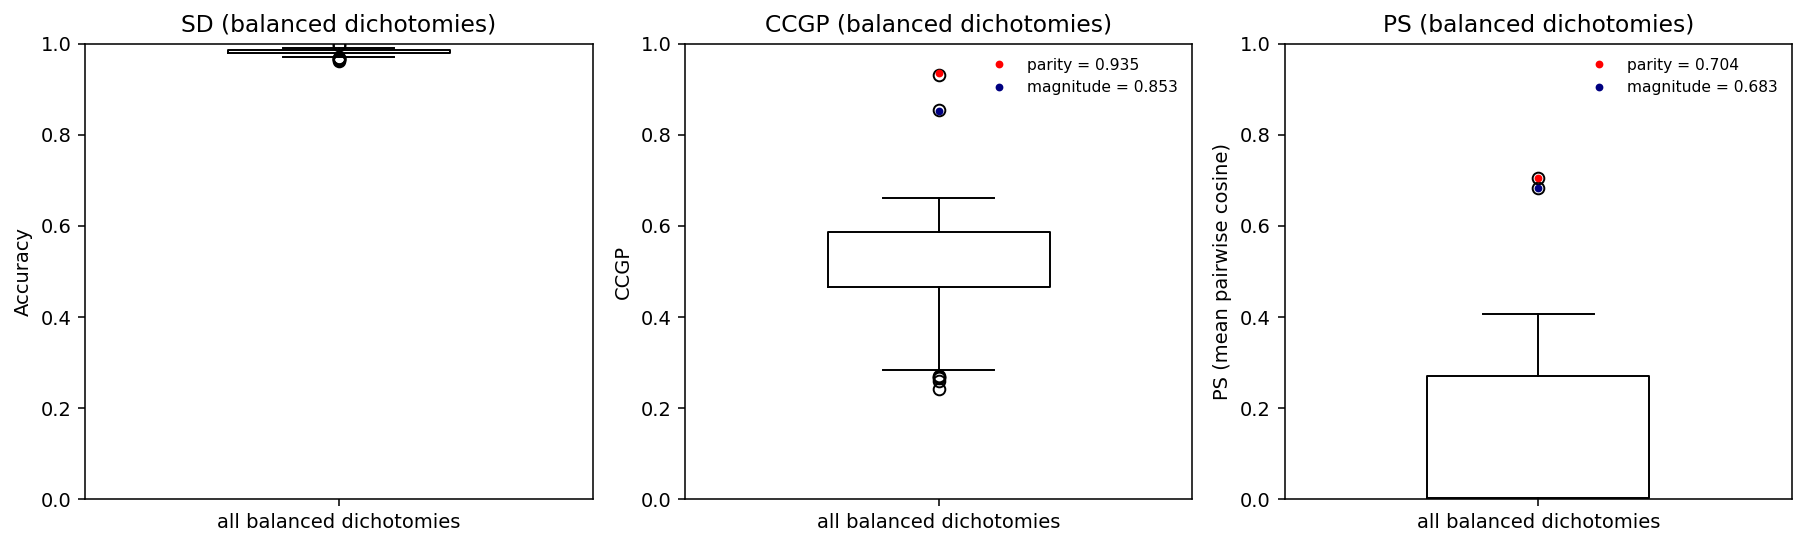

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


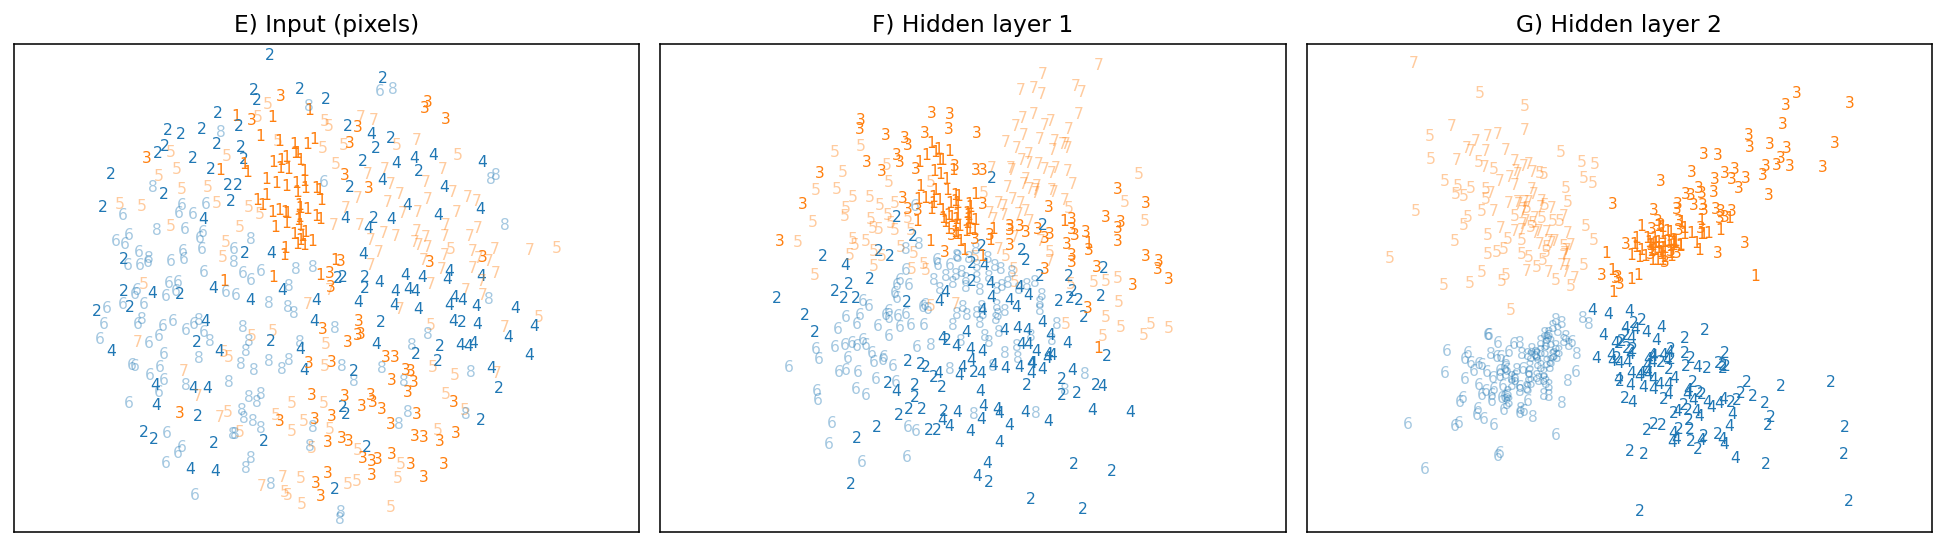

In [ ]:
#@title Figure 그리기

def box_with_points(ax, values, title, ylabel,
                    specials=None, jitter=0.05, ms=3):
    vals = np.asarray(values, dtype=float)
    x0 = 1.0

    ax.boxplot([vals], positions=[x0], widths=[0.35], vert=True,
               showmeans=False,
               medianprops=dict(color='none'))

    if specials:
        color_map = {"parity": "red", "magnitude": "navy"}
        offsets = [0, 0]
        for k, item in enumerate(specials):
            lab, v = item[0], float(item[1])
            ax.plot([x0 + offsets[k % len(offsets)]], [v],
                    marker='o', linestyle='none',
                    markersize=ms, color=color_map.get(lab, "black"),
                    label=f"{lab} = {v:.3f}", zorder=4)
        ax.legend(loc="best", fontsize=8, frameon=False)

    ax.set_xlim(0.6, 1.4)
    ax.set_ylim(0.0, 1.0)
    ax.set_xticks([x0]); ax.set_xticklabels(["all balanced dichotomies"])
    ax.set_title(title); ax.set_ylabel(ylabel)

fig, axes = plt.subplots(1, 3, figsize=(13, 4), dpi=140)

box_with_points(axes[0], sd_vals,
                title="SD (balanced dichotomies)",
                ylabel="Accuracy")

box_with_points(axes[1], ccgp_all,
                title="CCGP (balanced dichotomies)",
                ylabel="CCGP",
                specials=[("parity", ccgp_par, "--"),
                          ("magnitude", ccgp_mag, ":")])

box_with_points(axes[2], ps_all,
                title="PS (balanced dichotomies)",
                ylabel="PS (mean pairwise cosine)",
                specials=[("parity", ps_par, "--"),
                          ("magnitude", ps_mag, ":")])

plt.tight_layout()
plt.show()

@torch.no_grad()
def collect_for_mds(loader, per_digit=60):
    model.eval()
    buckets = {d:0 for d in range(1,9)}
    X_pix, X_h1, X_h2, Y = [], [], [], []
    for imgs, labels in loader:
        imgs = imgs.to(device)
        _, _, pix, h1, h2 = model(imgs, return_reprs=True)
        pix, h1, h2 = pix.cpu().numpy(), h1.cpu().numpy(), h2.cpu().numpy()
        labels = labels.numpy()
        for i in range(len(labels)):
            d = int(labels[i])
            if 1 <= d <= 8 and buckets[d] < per_digit:
                X_pix.append(pix[i]); X_h1.append(h1[i]); X_h2.append(h2[i]); Y.append(d)
                buckets[d] += 1
        if all(v>=per_digit for v in buckets.values()):
            break
    return np.stack(X_pix), np.stack(X_h1), np.stack(X_h2), np.array(Y)

X_E, X_F, X_G, y_d = collect_for_mds(train_loader, per_digit=60)

def run_mds(X, random_state=0, max_iter=300):
    return MDS(n_components=2, metric=True, random_state=random_state,
               n_init=1, max_iter=max_iter, dissimilarity='euclidean').fit_transform(X)

Z_E, Z_F, Z_G = run_mds(X_E), run_mds(X_F), run_mds(X_G)

def _mds_color_alpha_for_digit(d):
    color = "#1f77b4" if (d % 2 == 0) else "#ff7f0e"  # even blue / odd orange
    alpha = 0.4 if (d >= 5) else 1.0                  # big lighter / small solid
    return color, alpha

def panel_with_numbers(ax, Z, y_digits, title):
    x, y = Z[:,0], Z[:,1]
    ax.scatter(x, y, s=0)  # autoscale trick
    for i in range(len(y_digits)):
        d = int(y_digits[i])
        c, a = _mds_color_alpha_for_digit(d)
        ax.text(x[i], y[i], str(d), ha="center", va="center", fontsize=8, color=c, alpha=a)
    pad_x = 0.05*(x.max()-x.min()+1e-9); pad_y = 0.05*(y.max()-y.min()+1e-9)
    ax.set_xlim(x.min()-pad_x, x.max()+pad_x); ax.set_ylim(y.min()-pad_y, y.max()+pad_y)
    ax.set_aspect("equal", adjustable="datalim")
    ax.set_title(title); ax.set_xticks([]); ax.set_yticks([])

fig, axes = plt.subplots(1,3, figsize=(14,4), dpi=140)
panel_with_numbers(axes[0], Z_E, y_d, "E) Input (pixels)")
panel_with_numbers(axes[1], Z_F, y_d, "F) Hidden layer 1")
panel_with_numbers(axes[2], Z_G, y_d, "G) Hidden layer 2")
plt.tight_layout()
plt.show()